In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS
# -------------------------------------------------------------------------
# Suponemos que 'df' es tu DataFrame original
df = pd.read_csv('../data/processed/clean_data.csv') 

# Definir X (features) e y (target)
target_col = "Target_MntWinesYear"

# Asegúrate de eliminar el target de X y cualquier columna que no sea numérica
# o que ya hayas codificado (OneHotEncoding, etc.) previamente.
X = df.drop(columns=[target_col, 'ID', 'Target_Campaign_Responsiveness']) # Eliminamos también el otro target y el 'ID'
y = df[target_col]

# Split de entrenamiento y prueba (Hold-out set para validación final)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=11,
    shuffle=True # Por si los datos llegaran con algún orden
)

# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS
# -------------------------------------------------------------------------

# Diccionario para almacenar los mejores modelos
best_models = {}

# Definimos los modelos base
models = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVM': SVR()
}

# Definimos los grids de hiperparámetros
# NOTA: Usamos 'model__' como prefijo porque usaremos un Pipeline
param_grids = {
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'],
        'model__epsilon': [0.1, 0.2]
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH CON PIPELINE
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para predecir: {target_col}...\n")

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---")
    
    # Creamos el Pipeline: 
    # Paso 1: Escalar datos (MinMax)
    # Paso 2: Modelo Regresor
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    # Usamos una Cross-Validation en 3 partes con shuffle=True por si los datos llegaran ordenados
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Configuración de GridSearchCV
    # scoring='neg_root_mean_squared_error' es la métrica RMSE en sklearn (negativa para maximizar)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=kf,                             # 5-Fold Cross Validation
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,                        # Usar todos los núcleos del procesador
        verbose=3
    )
    
    # Entrenar
    grid.fit(X_train, y_train)
    
    # Guardar el mejor modelo
    best_models[model_name] = grid.best_estimator_
    
    # Resultados
    best_rmse = -grid.best_score_ # Convertimos de negativo a positivo
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor RMSE (Cross-Validation): {best_rmse:.4f}\n")

# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---")
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    final_mae = mean_absolute_error(y_test, y_pred)
    final_r2_score = r2_score(y_test, y_pred)    
    results.append({'Modelo': name, 'RMSE Test': final_rmse, 'MAE Test': final_mae, 'R2 Score Test': final_r2_score})
# Mostrar tabla comparativa
results_df = pd.DataFrame(results).sort_values(by='RMSE Test')
print(results_df)

Iniciando búsqueda de hiperparámetros para predecir: Target_MntWinesYear...

--- Optimizando XGBoost ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
Mejor RMSE (Cross-Validation): 82.2752

--- Optimizando RandomForest ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Mejor RMSE (Cross-Validation): 82.7287

--- Optimizando SVM ---
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejores parámetros: {'model__C': 100, 'model__epsilon': 0.2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Mejor RMSE (Cross-Validation): 101.9724

--- Evaluación Final en Test Set ---
         Modelo  RMSE Test   MAE Test  R2 Score Test
0       XGBoost  77.767821  40.390315       0.771142
1  RandomForest  81.

In [2]:
# XGBoost es el que mejores resutados nos da, seguido de cerca de RandomForest
# Lanzamos una segunda vuelta de ejecución de los modelos para ver si podemos ajustarlos mediante  hiperparametrización:


# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS
# -------------------------------------------------------------------------

# Diccionario para almacenar los mejores modelos
best_models = {}

# Definimos los modelos base
models = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVM': SVR()
}

# Definimos los grids de hiperparámetros
# NOTA: Usamos 'model__' como prefijo porque usaremos un Pipeline
param_grids = {
    'XGBoost': {
        'model__n_estimators': [200, 220, 240],
        'model__learning_rate': [0.07, 0.08, 0.09],
        'model__max_depth': [4, 5, 6],
        'model__subsample': [0.07, 0.75, 0.08]
    },
    'RandomForest': {
        'model__n_estimators': [90, 100, 110],
        'model__max_depth': [None, 4, 5, 6],
        'model__min_samples_split': [2,3,4,5,6],
        'model__min_samples_leaf': [2,3,4]
    },
    'SVM': {
        'model__C': [95, 100, 105],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'],
        'model__epsilon': [0.1, 0.18, 0.2, 0.22]
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH CON PIPELINE
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para predecir: {target_col}...\n")

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---")
    
    # Creamos el Pipeline: 
    # Paso 1: Escalar datos (MinMax)
    # Paso 2: Modelo Regresor
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    # Usamos una Cross-Validation en 3 partes con shuffle=True por si los datos llegaran ordenados
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Configuración de GridSearchCV
    # scoring='neg_root_mean_squared_error' es la métrica RMSE en sklearn (negativa para maximizar)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=kf,                             # 5-Fold Cross Validation
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,                        # Usar todos los núcleos del procesador
        verbose=3
    )
    
    # Entrenar
    grid.fit(X_train, y_train)
    
    # Guardar el mejor modelo
    best_models[model_name] = grid.best_estimator_
    
    # Resultados
    best_rmse = -grid.best_score_ # Convertimos de negativo a positivo
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor RMSE (Cross-Validation): {best_rmse:.4f}\n")

# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---")
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    final_mae = mean_absolute_error(y_test, y_pred)
    final_r2_score = r2_score(y_test, y_pred)    
    results.append({'Modelo': name, 'RMSE Test': final_rmse, 'MAE Test': final_mae, 'R2 Score Test': final_r2_score})
# Mostrar tabla comparativa
results_df = pd.DataFrame(results).sort_values(by='RMSE Test')
print(results_df)

Iniciando búsqueda de hiperparámetros para predecir: Target_MntWinesYear...

--- Optimizando XGBoost ---
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores parámetros: {'model__learning_rate': 0.08, 'model__max_depth': 6, 'model__n_estimators': 220, 'model__subsample': 0.75}
Mejor RMSE (Cross-Validation): 80.4953

--- Optimizando RandomForest ---
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Mejor RMSE (Cross-Validation): 82.8378

--- Optimizando SVM ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros: {'model__C': 105, 'model__epsilon': 0.22, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Mejor RMSE (Cross-Validation): 101.7644

--- Evaluación Final en Test Set ---
         Modelo  RMSE Test   MAE Test  R2 Score Test
0       XGBoost  75.413679  38.276386       0.784788
1  RandomFor

In [3]:
# Observamos que tras la segunda vuelta XGBoost ha mejorado. 
# Los otros 2 modelos no han variado mucho, la mejoría es muy pequeña
# XGBoost es el que mejores resutados nos da, seguido de cerca de RandomForest
# Lanzamos una segunda vuelta de ejecución de los modelos para ver si podemos ajustarlos mediante  hiperparametrización:


# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN DE MODELOS Y PARÁMETROS
# -------------------------------------------------------------------------

# Diccionario para almacenar los mejores modelos
best_models = {}

# Definimos los modelos base
models = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVM': SVR()
}

# Definimos los grids de hiperparámetros
# NOTA: Usamos 'model__' como prefijo porque usaremos un Pipeline
param_grids = {
    'XGBoost': {
        'model__n_estimators': [210, 220, 230],
        'model__learning_rate': [0.075, 0.08, 0.085],
        'model__max_depth': [6, 7],
        'model__subsample': [0.7, 0.75, 0.8]
    },
    'RandomForest': {
        'model__n_estimators': [95, 100, 105],
        'model__max_depth': [None, 4, 5, 6, 7],
        'model__min_samples_split': [2,3,4],
        'model__min_samples_leaf': [2,3,4]
    },
    'SVM': {
        'model__C': [100, 105, 110],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear'],
        'model__epsilon': [0.21, 0.22, 0.23, 0.24]
    }
}

# -------------------------------------------------------------------------
# 3. EJECUCIÓN DEL GRID SEARCH CON PIPELINE
# -------------------------------------------------------------------------

print(f"Iniciando búsqueda de hiperparámetros para predecir: {target_col}...\n")

for model_name, model_inst in models.items():
    print(f"--- Optimizando {model_name} ---")
    
    # Creamos el Pipeline: 
    # Paso 1: Escalar datos (MinMax)
    # Paso 2: Modelo Regresor
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('model', model_inst)
    ])

    # Usamos una Cross-Validation en 3 partes con shuffle=True por si los datos llegaran ordenados
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Configuración de GridSearchCV
    # scoring='neg_root_mean_squared_error' es la métrica RMSE en sklearn (negativa para maximizar)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        cv=kf,                             # 5-Fold Cross Validation
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,                        # Usar todos los núcleos del procesador
        verbose=3
    )
    
    # Entrenar
    grid.fit(X_train, y_train)
    
    # Guardar el mejor modelo
    best_models[model_name] = grid.best_estimator_
    
    # Resultados
    best_rmse = -grid.best_score_ # Convertimos de negativo a positivo
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor RMSE (Cross-Validation): {best_rmse:.4f}\n")

# -------------------------------------------------------------------------
# 4. EVALUACIÓN FINAL EN TEST SET
# -------------------------------------------------------------------------
print("--- Evaluación Final en Test Set ---")
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    final_mae = mean_absolute_error(y_test, y_pred)
    final_r2_score = r2_score(y_test, y_pred)    
    results.append({'Modelo': name, 'RMSE Test': final_rmse, 'MAE Test': final_mae, 'R2 Score Test': final_r2_score})
# Mostrar tabla comparativa
results_df = pd.DataFrame(results).sort_values(by='RMSE Test')
print(results_df)

Iniciando búsqueda de hiperparámetros para predecir: Target_MntWinesYear...

--- Optimizando XGBoost ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejores parámetros: {'model__learning_rate': 0.08, 'model__max_depth': 6, 'model__n_estimators': 210, 'model__subsample': 0.75}
Mejor RMSE (Cross-Validation): 80.4830

--- Optimizando RandomForest ---
Fitting 3 folds for each of 135 candidates, totalling 405 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Mejor RMSE (Cross-Validation): 82.8378

--- Optimizando SVM ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros: {'model__C': 110, 'model__epsilon': 0.24, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Mejor RMSE (Cross-Validation): 101.5744

--- Evaluación Final en Test Set ---
         Modelo  RMSE Test   MAE Test  R2 Score Test
0       XGBoost  75.395206  38.332583       0.784894
1  RandomFor

--- Generando Gráficos de Importancia de Variables ---


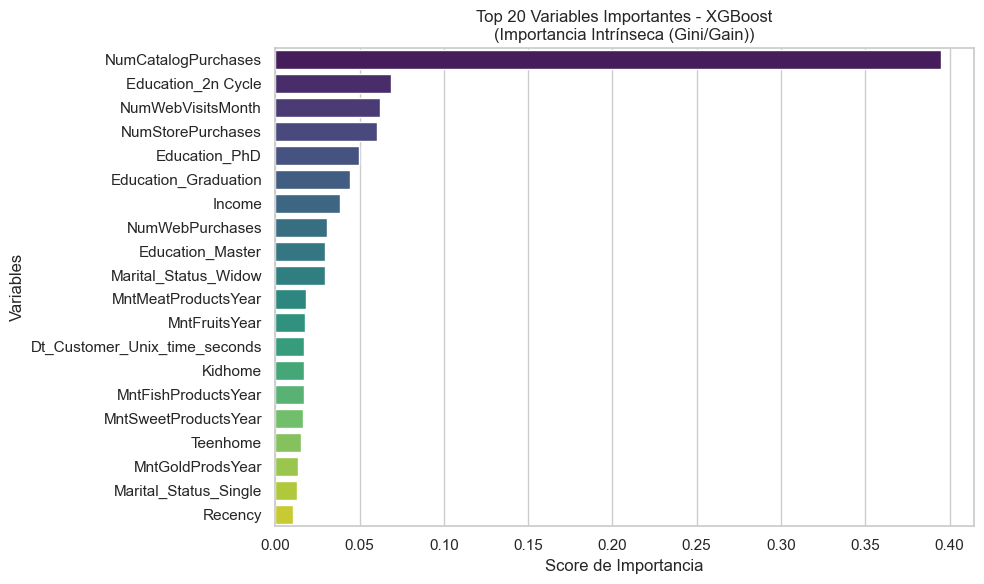

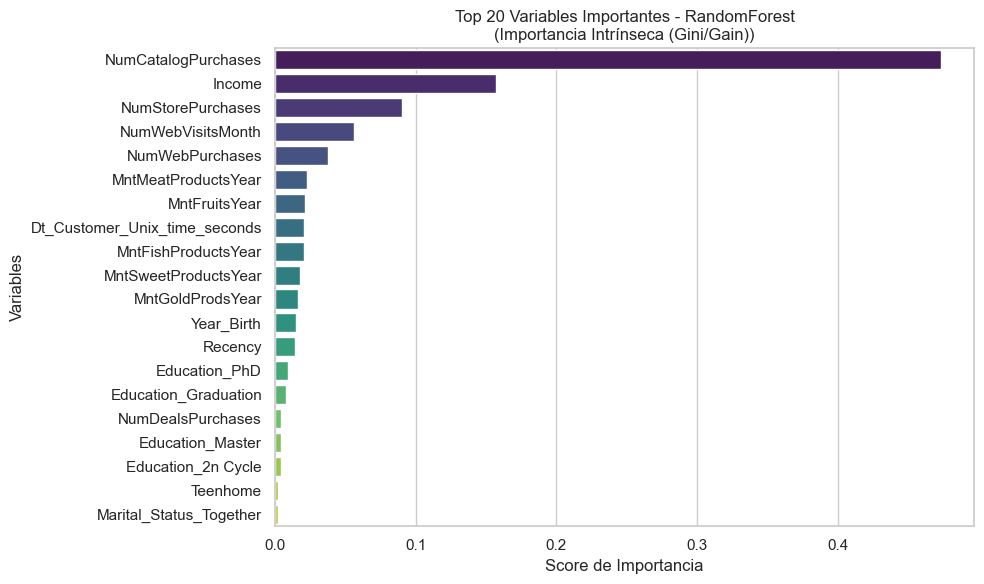

Calculando Permutation Importance para SVM (esto puede tardar un poco)...


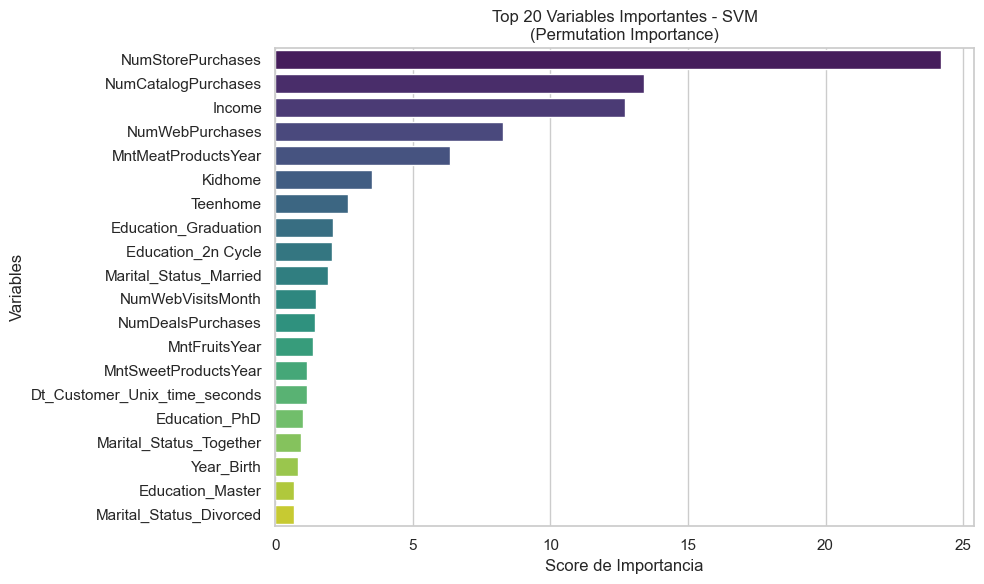

In [4]:
# En las siguientes líneas revisaremos cuál es la importancia que da cada modelo a las variables de entrada (predictoras)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Configuración de estilo de gráficos
sns.set(style="whitegrid")

def plot_feature_importance(model_pipeline, model_name, X_data, y_data, feature_names):
    """
    Función para graficar la importancia de las variables.
    Detecta automáticamente si usar importancia intrínseca o Permutation Importance.
    """
    
    # Extraemos el modelo final del pipeline
    model_step = model_pipeline.named_steps['model']
    
    importances = None
    method_name = ""

    # CASO A: Modelos de Árboles (XGBoost, RandomForest)
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
        method_name = "Importancia Intrínseca (Gini/Gain)"
        
    # CASO B: SVM (o modelos sin feature_importances_)
    else:
        print(f"Calculando Permutation Importance para {model_name} (esto puede tardar un poco)...")
        # Usamos el pipeline completo aquí para que escale los datos al permutar
        perm_result = permutation_importance(
            model_pipeline, X_data, y_data, 
            n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error'
        )
        importances = perm_result.importances_mean
        method_name = "Permutation Importance"

    # Crear DataFrame para facilitar el gráfico
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Visualización
    plt.figure(figsize=(10, 6))
    
    # Graficamos solo las Top 20 features para no saturar si hay muchas columnas
    top_n = 20
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df.head(top_n), 
        palette='viridis',
        hue='Feature' # Asignar hue a Feature para evitar advertencia de deprecación futura
    )
    
    plt.title(f'Top {top_n} Variables Importantes - {model_name}\n({method_name})')
    plt.xlabel('Score de Importancia')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------------
# EJECUCIÓN DE LAS GRÁFICAS
# -------------------------------------------------------------------------
print("--- Generando Gráficos de Importancia de Variables ---")

# Obtenemos los nombres de las columnas
feature_names = X_train.columns

for name, pipeline in best_models.items():
    # Para Permutation Importance (SVM) es mejor usar el set de Test o un set de validación
    # Para Árboles es indiferente, pero usaremos X_test para consistencia en la evaluación
    plot_feature_importance(pipeline, name, X_test, y_test, feature_names)

In [5]:
mae_score = 38.33
print("Media 'Target_MntWinesYear':", df["Target_MntWinesYear"].mean())
print("MAE:", mae_score)
print("% MAE - Media:", round(mae_score/df["Target_MntWinesYear"].mean()*100,2), "%")


Media 'Target_MntWinesYear': 152.64376130198914
MAE: 38.33
% MAE - Media: 25.11 %


In [2]:
# Al revisar la importancia que se da a las variables , vemos que en apariencia RandomForest podría hacer mejores predicciones con 
# menos variables. Esto sería una ventaja si tuviéramos mucha fricción para conseguir ciertos datos de cliente.

# Sin embargo, dado que ya disponemos de todos los datos de cliente y de sus hábitos en nuestro sistema, nos vamos 
# a XGBoost por ser el que mejores métricas nos da, tanto en RMSE como en MAE y R2 Score.
# Los hiperparámetros a utilizar son estos:

best_model_selected = Pipeline([
                        ('scaler', MinMaxScaler()), 
                        ('model', XGBRegressor(
                                    objective='reg:squarederror',
                                    random_state=42,
                                    n_estimators=210,
                                    learning_rate=0.08,
                                    max_depth=6,
                                    subsample=0.75
                                ))
                    ])


In [3]:
# Nos aseguramos de que responde como esperamos:
best_model_selected.fit(X_train, y_train)
y_pred = best_model_selected.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)
final_r2_score = r2_score(y_test, y_pred)

print('RMSE Test:', final_rmse)
print('MAE Test:', final_mae)
print('R2 Score Test:', final_r2_score)

RMSE Test: 75.39520573598405
MAE Test: 38.33258345010049
R2 Score Test: 0.7848936540828191


In [ ]:
# Se trata de los resultados esperados, ya tenemos nuestro modelo funcionando

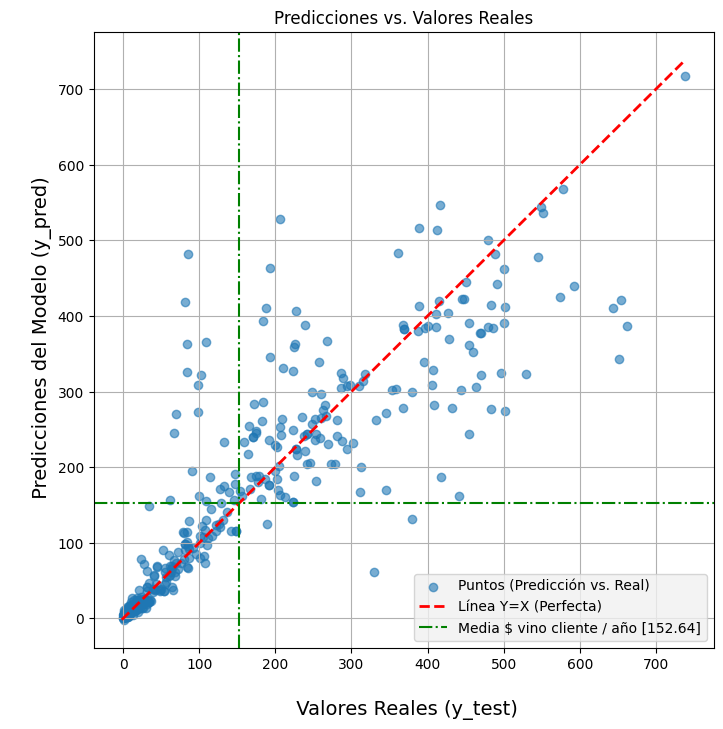

In [16]:
# Vamos a probar a representar en un gráfico las predicciones vs los valores reales:
import pandas as pd
import matplotlib.pyplot as plt

CONSUMO_MEDIO_VINO_POR_CLIENTE = np.round(df["Target_MntWinesYear"].mean(), 2) #

# Crear un DataFrame para facilitar la visualización con seaborn
df_results = pd.DataFrame({'Valores Reales (Y_test)': y_test, 
                           'Predicciones': y_pred})

plt.figure(figsize=(8, 8))
plt.scatter(df_results['Valores Reales (Y_test)'], df_results['Predicciones'], 
            alpha=0.6, label='Puntos (Predicción vs. Real)')

# Añadir la línea de referencia Y=X (Predicción Perfecta)
max_val = max(df_results['Valores Reales (Y_test)'].max(), df_results['Predicciones'].max())
min_val = min(df_results['Valores Reales (Y_test)'].min(), df_results['Predicciones'].min())
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2, label='Línea Y=X (Perfecta)')

# --- AÑADIR LA LÍNEA HORIZONTAL EN Y=CONSUMO_MEDIO_VINO_POR_CLIENTE ---
plt.axhline(y=CONSUMO_MEDIO_VINO_POR_CLIENTE, 
            color='green',          # Color de la línea (ej. verde)
            linestyle='-.',         # Estilo de la línea (ej. punto-raya)
            linewidth=1.5,          # Grosor de la línea
            label=f"Media $ vino cliente / año [{CONSUMO_MEDIO_VINO_POR_CLIENTE}]"    # Etiqueta para la leyenda
           )

# --- AÑADIR LA LÍNEA VERTICAL EN X=CONSUMO_MEDIO_VINO_POR_CLIENTE ---
plt.axvline(x=CONSUMO_MEDIO_VINO_POR_CLIENTE, 
            color='green',          # Color de la línea (ej. verde)
            linestyle='-.',         # Estilo de la línea (ej. punto-raya)
            linewidth=1.5,          # Grosor de la línea
            #label=f"Media $ vino cliente / año [{CONSUMO_MEDIO_VINO_POR_CLIENTE}]"    # Etiqueta para la leyenda
           )

plt.title('Predicciones vs. Valores Reales')
plt.xlabel('\n Valores Reales (y_test)', fontsize=14)
plt.ylabel('\n Predicciones del Modelo (y_pred)', fontsize=14)
plt.grid(True)
plt.legend(facecolor='#f0f0f0')
plt.show()